<a href="https://colab.research.google.com/github/wiredastronaut/stableDiffusion/blob/main/Diffusion/Probabilistic-Models/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from matplotlib import pyplot as plt
import random
import numpy as np

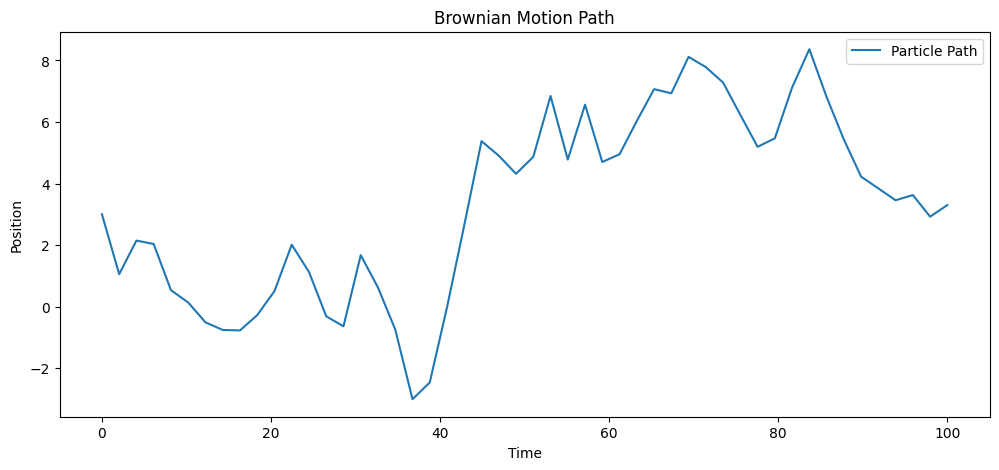

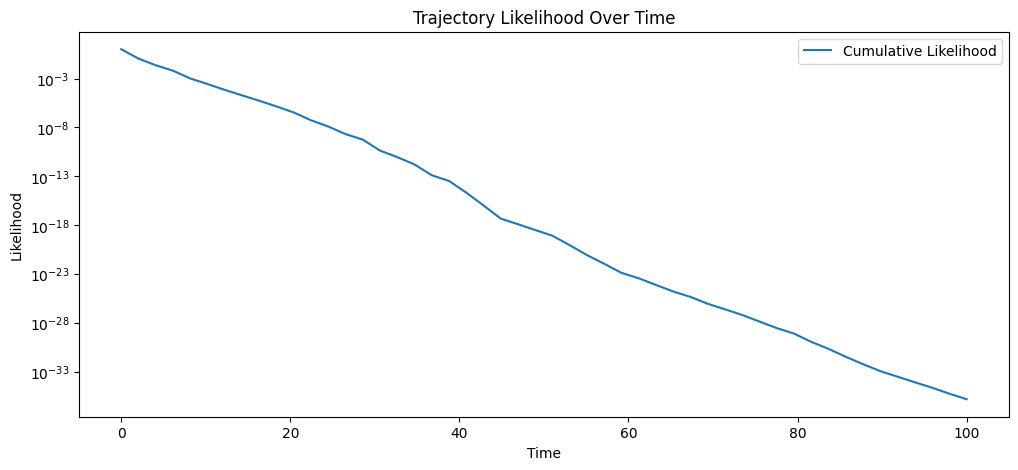

In [ ]:
## Forward Diffusion
T = 100 # diffusion steps
#Forward diffusion Kernel (App 1) defined as
# NormalDist at x^t, w/mean = x^(t-1) * sqrt(1 - beta_t) w/ sigma = identity * beta



## Basic Brownian Motion
'''
So refresh my memory - why is the following an example of brownian motion? And what is brownian motion

The example I continually come across is if particles in water were observed to move
in a random way. Where a given path consists of a series of state transitions that occur
with a given probability. Essentially if a particle's path is exhibiting brownian motion it will
seem to move randomly over time. Specifically this is captured with 3 main properties
1. The path the particle takes is continuous (ie. not discrete jumps)
2. The positional step from one time to the next is zero mean and the varinance is
proportional with time (longer time = longer step)
3. The process is a markovian process.

A markovian process means the state change from time 1 to time 2 is dependent only on
the current state at time 1. In a general way this means the future is only dependent
on the present, not the past.

Brownian motion is essentially a good example of diffusion which is why I'm focusing
on it here. It serves as a basic example of how motion can move.




Defining the probability function of the diffusion process for Brownian motion.

- So property 2 states that the positional step from one time to the next (given by
a time delta of t) is zero mean, and the variance is based on the time delta, t. Thus the
probability density function can be given using the gaussian function.

u(x, t) = 1/(2*pi*t)*exp(-x^2/(2*t))

In the below code we actually randomly sample from the above distribution. So we can use
the above formula to say what the probability of x being a specfic value (like 2) for example is.
With x being the step from one point to another. So in the below code we have the
formula for going from position y to position x (ie. a step sampled via the gaussian). We then
use that step value, formulate the probability density function, and identify the probability
associated with getting the specific step value, with the given time.

Heat equation (or forward equation)

partial w.r.t. t of u = 1/2 * partial w.r.t. x sqaured of u

This equation allows us to describe how diffusion occurs. The probability density
function of our path going frmo y  to x , Xt (for brownian motion) can be found using Bayes rule for
a markov property

= integral over initial_prob(initial_state) * Gaussian(to_state, current_state, ttime) dy

Th integral piece captures all the potential initial states. This can be reorganized
into the heat equation shown above. Essentially, the probability desnity function
of brownian motion is a form of the heat equation/forward equation.

Next, I'm in lecture 1 near equation 11 moving to backward equation.





'''
ts = np.linspace(0, 100, 50)
# Distribution
*
initial_position = 3
position_t = []
density_t = []
density_t.append(1)
position_t.append(initial_position)
for i in range(1, len(ts)):
  t1 = ts[i-1]
  t2 = ts[i]
  position_step = random.gauss(0, np.sqrt(t2 - t1))
  #Property 2, positional step are gaussian of zero mean and variance according to the timestep
  new_position = position_t[-1] + position_step
  #Find the transition probability From y to x
  y = position_t[-1]
  x = new_position
  transition_density = 1/(np.sqrt(2 * np.pi * (t2 - t1))) * np.exp(-((x - y)**2)/(2 * (t2 - t1)))

  #Property 3, the motion is markov based (ie. only dependent on current position)
  position_t.append(new_position)
  #Probability of observing x given y = p(y) * p(x|y)
  density_t.append(density_t[-1] * transition_density)

plt.figure(figsize=(12, 5))
plt.plot(ts, position_t, label="Particle Path")
plt.title("Brownian Motion Path")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend()
plt.show()

# Plot likelihood evolution
plt.figure(figsize=(12, 5))
plt.plot(ts, density_t, label="Cumulative Likelihood")
plt.title("Trajectory Likelihood Over Time")
plt.xlabel("Time")
plt.ylabel("Likelihood")
plt.yscale("log")  # Log scale for better visualization of decreasing likelihood
plt.legend()
plt.show()

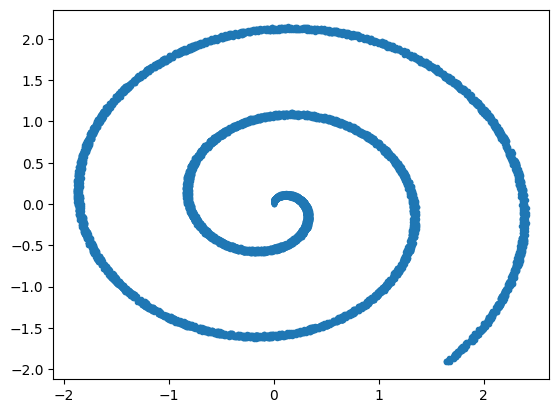

In [ ]:
# NOw move on to the swiss roll distribution
# set parameters
length_phi = 15   #length of swiss roll in angular direction
sigma = 0.3  #noise strength
m = 10000     #number of samples
#create the dataset
phi = length_phi * np.random.rand(m)
xi = np.random.rand(m)
X = 1./6*(phi + sigma*xi)*np.sin(phi)
Y = 1./6*(phi + sigma*xi)*np.cos(phi)
swiss_roll = np.array([X, Y]).transpose()
# now display
plt.scatter(X, Y, marker=".")


In [ ]:
#We want to essentially add noise at T timesteps according to the kernel

#Beta (diffusion rate) - will step at a constant rate
T = 100

beta = np.linspace(0, .1, T)
print(beta)





def transition_kernel(beta, x_minus_1_in):
  """
  Simulates the forward diffusion process. x_minus_1_in is the initial data
  beta is the current beta

  """
  if len(x_minus_1_in.shape) < 2:
    x_minus_1 = np.reshape(x_minus_1_in, [x_minus_1_in.shape[0], 1])
  mu = x_minus_1 * np.sqrt(1 - beta)
  cov = np.eye(x_minus_1.shape[0]) * beta
  x_1 = np.zeros((x_minus_1.shape[0], 1))

  #Sample in uniform distribtuion which will then be offset by the new calculated mu
  #and scaled by the new standard deviation.
  for i in range(0, x_minus_1.shape[0]):
    x_1[i, 0] = random.gauss(0, 1)

  sampled_value = mu + np.sqrt(cov) @ x_1
  #Returns the probability associated with x_1 of the distribution
  #formed with x_minus_1, and beta (see paper)
  if beta > 0:
    probability =  (2 * np.pi)**(-x_1.shape[0]/2) * (np.linalg.det(cov))**(-.5) * np.exp(
        -.5 * (x_1 - mu).transpose() @ np.linalg.inv(cov) @ (x_1 - mu)
      )
  else:
    probability = np.ones((mu.shape))


  return (sampled_value, probability)


XY = np.vstack((X, Y))
XY_new = np.zeros((XY.shape))
XY_arr = []
XY_arr.append(XY)
for t in range(0, T):
  print('t: ', t)
  for i in range(0, XY.shape[1]):
    xy_new, newP = transition_kernel(beta[t], XY[:, i])
    XY_new[:, i] = xy_new[:, 0]
  XY_arr.append(XY_new)
  XY = XY_new






[0.         0.0010101  0.0020202  0.0030303  0.0040404  0.00505051
 0.00606061 0.00707071 0.00808081 0.00909091 0.01010101 0.01111111
 0.01212121 0.01313131 0.01414141 0.01515152 0.01616162 0.01717172
 0.01818182 0.01919192 0.02020202 0.02121212 0.02222222 0.02323232
 0.02424242 0.02525253 0.02626263 0.02727273 0.02828283 0.02929293
 0.03030303 0.03131313 0.03232323 0.03333333 0.03434343 0.03535354
 0.03636364 0.03737374 0.03838384 0.03939394 0.04040404 0.04141414
 0.04242424 0.04343434 0.04444444 0.04545455 0.04646465 0.04747475
 0.04848485 0.04949495 0.05050505 0.05151515 0.05252525 0.05353535
 0.05454545 0.05555556 0.05656566 0.05757576 0.05858586 0.05959596
 0.06060606 0.06161616 0.06262626 0.06363636 0.06464646 0.06565657
 0.06666667 0.06767677 0.06868687 0.06969697 0.07070707 0.07171717
 0.07272727 0.07373737 0.07474747 0.07575758 0.07676768 0.07777778
 0.07878788 0.07979798 0.08080808 0.08181818 0.08282828 0.08383838
 0.08484848 0.08585859 0.08686869 0.08787879 0.08888889 0.0898

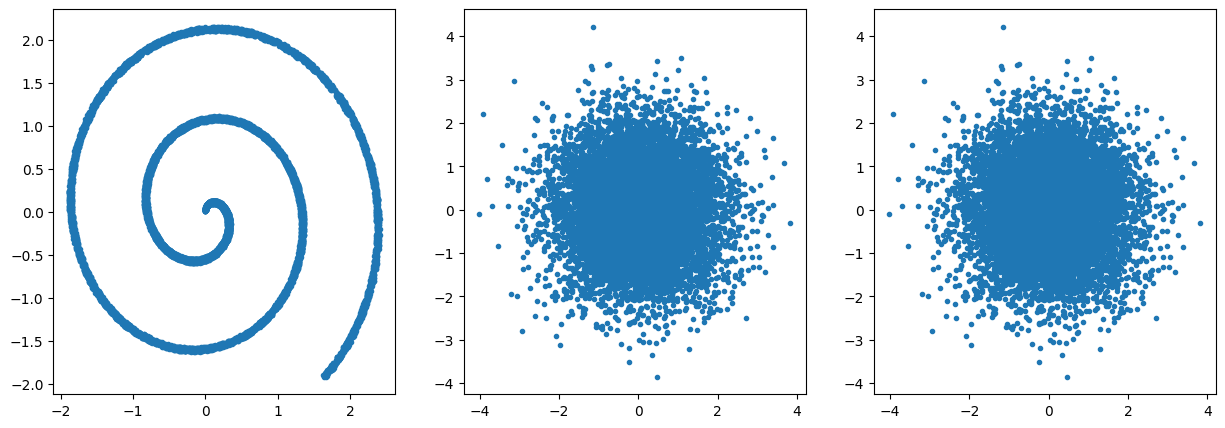

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131)
XY = XY_arr[0]
ax.scatter(XY[0,:], XY[1,:], marker=".")

ax = fig.add_subplot(132)
XY = XY_arr[50]
ax.scatter(XY[0,:], XY[1,:], marker=".")

ax = fig.add_subplot(133)
XY = XY_arr[-1]
ax.scatter(XY[0,:], XY[1,:], marker=".")

In [ ]:
import torch
import numpy as np

In [ ]:
def true_posterior(alphas, betas, x0, xt, idx):
  mu = (torch.sqrt(1 - betas[idx]) * alphas[idx-1]/alphas[idx] * x0) + (torch.sqrt(betas[idx]) * (1 - alphas[idx-1])/alphas[idx] * xt)
  variance = (1 - alphas[idx-1]) * betas[idx]/alphas[idx]
  return (mu, variance)


In [ ]:
import torch.nn as nn

import torch
import torch.nn as nn

class ReverseDiffusionNetwork(nn.Module):
    def __init__(self, input_dim, time_dim, hidden_dim=128, num_layers=3):
        """
        Neural network for approximating the reverse mean (mu_theta).
        Args:
            input_dim: Dimensionality of x_t.
            time_dim: Dimensionality of the time embedding.
            hidden_dim: Number of hidden units per layer.
            num_layers: Number of layers in the network.
        """

        #Base class
        super().__init__()

        # Define layers
        layers = []
        input_size = input_dim + time_dim  # x_t + time embedding as input
        for _ in range(num_layers):
            #fully connected layer
            layers.append(nn.Linear(input_size, hidden_dim))
            #add activation function
            layers.append(nn.ReLU())
            input_size = hidden_dim

        self.shared_layers = nn.Sequential(*layers)
        #Make the layers sequential
        #* -> that expands the individual layers so they can be taken as argumnets


        # Define separate heads for mean and log-variance
        self.mean_head = nn.Linear(hidden_dim, input_dim)  # Predict mu_theta
        self.logvar_head = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),  # Linear transformation
            nn.Sigmoid()                       # Apply sigmoid activation
        )
    def forward(self, x_t, t):
        """
        Forward pass through the network.
        Args:
            x_t: Noisy data at time t (batch_size, input_dim).
            t: Scalar time index (batch_size, time_dim).
        Returns:
            mu_theta: Predicted mean (batch_size, input_dim).
            log_sigma_theta: Predicted log-variance (batch_size, input_dim).
        """
        x_t = x_t.to(next(self.parameters()).dtype)
        t = t.to(next(self.parameters()).dtype)

        # Combine x_t and time embedding
        input_data = torch.cat([x_t, t], dim=-1)
        shared_output = self.shared_layers(input_data)

        # Compute mean and log-variance
        mu_theta = self.mean_head(shared_output)
        log_sigma_theta = self.logvar_head(shared_output)

        return mu_theta, log_sigma_theta



In [ ]:
def kl_divergence(true_mu, est_mu, log_true_var, log_est_var):

  est_var = torch.exp(log_est_var)
  true_var = torch.exp(log_true_var)
  true_var = torch.clamp(true_var, min=1e-8, max=1e2)
  est_var = torch.clamp(est_var, min=1e-8, max=1e2)
  mean_loss = torch.sum((true_mu - est_mu) ** 2/ est_var, dim = 1)
  var_loss = torch.sum(log_est_var - log_true_var + (true_var / est_var) - 1, dim=1)
  return torch.mean(0.5*(mean_loss + var_loss))


In [ ]:
# Reformulate the forward diffusion process to go faster
T = 100
betas = torch.linspace(1e-4, .1, steps=T)
#Allows beta to be learned
betas = torch.nn.Parameter(betas, requires_grad=True)
#Now constrain it using output of sigmoid (goes 0 to 1)


difnet = ReverseDiffusionNetwork(2, 1, 16, 3)

#x0, the initial data is our swiss roll (identified above)
x0 = torch.from_numpy(np.vstack((X, Y))).T
#initialize
x_t = x0
noisy_data = []
optimizer = torch.optim.Adam(list(difnet.parameters()) + [betas], lr=1e-5)
num_epochs = 100


for epoch in range(num_epochs):
  for i in range(T):
    torch.autograd.set_detect_anomaly(True)
    #Create m standard gaussian random points
    noise = torch.randn_like(x_t)
    #betas_constrained = betas

    #Forward step to update samples, beta_t should be a square covriance matrix as it
    #is a 2dimensional covariance. However
    # because it's gaussian the off-diagonal should be 0, and this should be the same operation
    #just vectorized using elementwise multiplication

    # identify alpha, recursive definition of beta
    alphas = torch.cumprod(1 - betas, dim=0)
    alpha_t = alphas[i]

    beta_t = betas[i]
    x_t = torch.sqrt(1 - beta_t) * x_t.detach() + torch.sqrt(beta_t) * noise

    #Get forward posterior for x_t
    [mu_truth, var_truth] = true_posterior(alphas, betas, x0, x_t, i)
    log_var_truth = torch.log(var_truth)

    #Get backward probability prediction
    #nomrlaize time
    t = i/T
    t = torch.full(( x_t.shape[0], 1), t)
    [mu_pred, log_var_pred] = difnet.forward(x_t, t)





    loss = kl_divergence(mu_truth, mu_pred, log_var_truth, log_var_pred)
    #print("Is betas a Parameter?", isinstance(betas, torch.nn.Parameter))
    #print("betas.requires_grad:", betas.requires_grad)
    #print("betas_constrained.requires_grad", betas_constrained.requires_grad)  # Should be True
    #print("betas.grad:", betas.grad)

    #pytorch traverses the computation graph in reverse order (from loss to inputs)
    #doing the back propagation
    #reset gradients
    optimizer.zero_grad()
    #torch.nn.utils.clip_grad_norm_(difnet.parameters(), max_norm=1.0)
    loss.backward()
    print('Epoch: ', epoch, 'itr: ', i, 'Loss', loss.item())
    #updates the parameters using the computerd gradiets
    optimizer.step()



Streaming output truncated to the last 5000 lines.
Epoch:  50 itr:  0 Loss 5.944525651513694
Epoch:  50 itr:  1 Loss 13.318808265174518
Epoch:  50 itr:  2 Loss 13.032894042776377
Epoch:  50 itr:  3 Loss 12.911473077936973
Epoch:  50 itr:  4 Loss 12.836740724339382
Epoch:  50 itr:  5 Loss 12.779729881728583
Epoch:  50 itr:  6 Loss 12.728482424083547
Epoch:  50 itr:  7 Loss 12.671955422990594
Epoch:  50 itr:  8 Loss 12.57998639100951
Epoch:  50 itr:  9 Loss 12.349025256476564
Epoch:  50 itr:  10 Loss 11.87647472255599
Epoch:  50 itr:  11 Loss 11.31077973959685
Epoch:  50 itr:  12 Loss 10.773557843402921
Epoch:  50 itr:  13 Loss 10.277837898927281
Epoch:  50 itr:  14 Loss 9.819316655426572
Epoch:  50 itr:  15 Loss 9.395469088179688
Epoch:  50 itr:  16 Loss 9.004458443515356
Epoch:  50 itr:  17 Loss 8.643979141355857
Epoch:  50 itr:  18 Loss 8.311365233983599
Epoch:  50 itr:  19 Loss 8.003743942172411
Epoch:  50 itr:  20 Loss 7.718394857145836
Epoch:  50 itr:  21 Loss 7.452751826149067
Epo

In [ ]:
loss.item()

4.75054990476955

In [ ]:
# Now true posterior can be found using alphas
#t = 10
#x0 = noisy_data[0]
#xt = noisy_data[t]




